## Trying to undestand the tandem mutant notebook

In [1]:
import re
import pandas as pd
import numpy as np
import statistics as st
import itertools as it
import matplotlib.pyplot as plt
import bokeh as bk
import pandas_bokeh as pd_bk
import seaborn as sns
pd_bk.output_notebook()

Loading BokehJS ...

In [2]:
# Target String one
str1 = "Emma's luck numbers are 251 761 231 451"

# pattern to find three consecutive digits
string_pattern = r"\d{3}"
# compile string pattern to re.Pattern object
regex_pattern = re.compile(string_pattern)

# print the type of compiled pattern
print(type(regex_pattern))
# Output <class 're.Pattern'>

# find all the matches in string one
result = regex_pattern.findall(str1)
print(result)
# Output ['251', '761', '231', '451']

# Target String two
str2 = "Kelly's luck numbers are 1110 021200 415"
# find all the matches in second string by reusing the same pattern
result = regex_pattern.findall(str2)
print(result)
# Output ['111', '212', '415']

<class 're.Pattern'>
['251', '761', '231', '451']
['111', '021', '200', '415']


In [4]:

str3 = """# $1: Aminoacid mutation in partner 1
# $2: Aminoacid mutation in partner 2
# $3: mean enrich tandem mutant, $4: stdev, $5: median, $6: quant_1st , $7: quant_2nd,
# $8: mean1 vs WT, $9: stdev1, $10: median1, $11: quant_1st1, $12: quant_2nd1,
# $13: mean2 vs WT, $14: stdev2, $15: median2, $16: quant_1st2, $17: quant_2nd2,
# $18: size in terms of number of bc, $19: size1, $20: size2
S30D	R32D			1.15	0.19	1.18	0.96	1.31	1.13	0.2	1.16	1.01	1.26	1.1	0.16	1.09	0.98	1.19	5	38	61
S30D	R32E			0.85	0.52	None	None	None	1.13	0.2	1.16	1.01	1.26	0.87	0.4	1.03	0.31	1.19	3	38	39
S30D	R32F			0.82	0.07	0.82	0.75	0.89	1.13	0.2	1.16	1.01	1.26	0.77	0.15	0.79	0.69	0.86	4	38	71
"""

regex_pattern = re.compile(r"\$\d+:\s?(.+?)[,\n]")
result = regex_pattern.findall(str3)
print(result)

['Aminoacid mutation in partner 1', 'Aminoacid mutation in partner 2', 'mean enrich tandem mutant', 'stdev', 'median', 'quant_1st ', 'quant_2nd', 'mean1 vs WT', 'stdev1', 'median1', 'quant_1st1', 'quant_2nd1', 'mean2 vs WT', 'stdev2', 'median2', 'quant_1st2', 'quant_2nd2', 'size in terms of number of bc', 'size1', 'size2']


In [5]:
column_name = list()
l_enrichment = list()
l_DOUBLEMUT_ENRICH_series = list()
DOUBLEMUT_ENRICH_file = f"VHH2_copy_ENRICH.out"

print(DOUBLEMUT_ENRICH_file)

comment_lines = ""
pat = re.compile(r"\$\d+:\s?(.+?)[,\n]")
#print(pat)
parse_comments = True
d_DOUBLEMUT_ENRICH_series = dict()
d_ordermut = dict(l_aa1 = [], l_aa2 = [],l_aa1_seen = [], l_aa2_seen = [], l_tandem = [])
s_mutation_not_seen_in_p1 = set()
s_mutation_not_seen_in_p2 = set()
s_mutation_seen_in_p1 = set()
s_mutation_seen_in_p2 = set()
for line in open(DOUBLEMUT_ENRICH_file).readlines():
    if line[0] == "#":
        comment_lines += line[1:]
        continue
    if parse_comments:
        column_name = pat.findall(comment_lines)
        print(column_name)
        parse_comments = False
        
    s = line.split()
    aamut1 = s[0]
    aamut2 = s[1]
    tandem_mut = "{}_{}".format(aamut1, aamut2)
    if aamut1 not in d_ordermut['l_aa1']:
        d_ordermut['l_aa1'].append(aamut1)
    if aamut2 not in d_ordermut['l_aa2']:
        d_ordermut['l_aa2'].append(aamut2)        
    if tandem_mut not in d_ordermut['l_tandem']:
        d_ordermut['l_tandem'].append(tandem_mut)
        
    if len(s) <= 3:
        continue
    s_mutation_seen_in_p1.add(aamut1)
    s_mutation_seen_in_p2.add(aamut2)

    d_DOUBLEMUT_ENRICH_series[tandem_mut] = s
s_mutation_not_seen_in_p1 = set(d_ordermut['l_aa1']) - s_mutation_seen_in_p1
s_mutation_not_seen_in_p2 = set(d_ordermut['l_aa2']) - s_mutation_seen_in_p2
    
    
for aamut1 in d_ordermut['l_aa1']:
    for aamut2 in d_ordermut['l_aa2']:
        tmut = "{}_{}".format(aamut1, aamut2)
        if tmut in d_DOUBLEMUT_ENRICH_series:
            l_DOUBLEMUT_ENRICH_series.append(d_DOUBLEMUT_ENRICH_series[tmut])

df_DOUBLEMUT_ENRICH = pd.DataFrame([pd.Series(l_DOUBLEMUT_ENRICH_series[x],index=column_name) for x in range(len(l_DOUBLEMUT_ENRICH_series))], columns = column_name)
df_DOUBLEMUT_ENRICH.replace('None', np.nan, inplace=True)
#for col in column_name[2:]:

l_property = ['mean enrich tandem mutant', 'mean1 vs WT', 'mean2 vs WT', 'stdev', 'stdev1', 'stdev2', 
              'size in terms of number of bc', 'size1', 'size2']
for prop in l_property:
    df_DOUBLEMUT_ENRICH[prop] = df_DOUBLEMUT_ENRICH[prop].astype(float)

print("Total number of mutations expected in p1: {}".format(len(d_ordermut['l_aa1'])))
print("Number of mutations observed in p1: {}".format(len(s_mutation_seen_in_p1)))
print("Total number of mutations expected in p2: {}".format(len(d_ordermut['l_aa2'])))
print("Number of mutations observed in p2: {}".format(len(s_mutation_seen_in_p2)))

print(type(df_DOUBLEMUT_ENRICH))
df_DOUBLEMUT_ENRICH

VHH2_copy_ENRICH.out
['Aminoacid mutation in partner 1', 'Aminoacid mutation in partner 2', 'mean enrich tandem mutant', 'stdev', 'median', 'quant_1st ', 'quant_2nd', 'mean1 vs WT', 'stdev1', 'median1', 'quant_1st1', 'quant_2nd1', 'mean2 vs WT', 'stdev2', 'median2', 'quant_1st2', 'quant_2nd2', 'size in terms of number of bc', 'size1', 'size2']
Total number of mutations expected in p1: 5
Number of mutations observed in p1: 5
Total number of mutations expected in p2: 22
Number of mutations observed in p2: 19
<class 'pandas.core.frame.DataFrame'>


,Aminoacid mutation in partner 1,Aminoacid mutation in partner 2,mean enrich tandem mutant,stdev,median,quant_1st,quant_2nd,mean1 vs WT,stdev1,median1,quant_1st1,quant_2nd1,mean2 vs WT,stdev2,median2,quant_1st2,quant_2nd2,size in terms of number of bc,size1,size2
0,S30D,R32D,1.15,0.19,1.18,0.96,1.31,1.13,0.20,1.16,1.01,1.26,1.10,0.16,1.09,0.98,1.19,5.0,38.0,61.0
1,S30D,R32E,0.85,0.52,NaN,NaN,NaN,1.13,0.20,1.16,1.01,1.26,0.87,0.40,1.03,0.31,1.19,3.0,38.0,39.0
2,S30D,R32F,0.82,0.07,0.82,0.75,0.89,1.13,0.20,1.16,1.01,1.26,0.77,0.15,0.79,0.69,0.86,4.0,38.0,71.0
3,S30D,R32G,1.12,0.00,NaN,NaN,NaN,1.13,0.20,1.16,1.01,1.26,0.98,0.12,0.96,0.88,1.05,1.0,38.0,19.0
4,S30D,R32K,1.19,0.00,NaN,NaN,NaN,1.13,0.20,1.16,1.01,1.26,0.99,0.20,0.93,0.84,1.13,1.0,38.0,23.0
5,S30E,S81F,0.17,0.01,NaN,NaN,NaN,1.16,0.22,1.18,0.94,1.36,0.18,0.06,0.17,0.13,0.2,2.0,23.0,58.0
6,S30E,S81G,0.42,0.00,NaN,NaN,NaN,1.16,0.22,1.18,0.94,1.36,0.31,0.11,0.32,0.27,0.37,1.0,23.0,24.0
7,S30E,S81K,0.00,0.00,NaN,NaN,NaN,1.16,0.22,1.18,0.94,1.36,0.08,0.05,0.08,0.07,0.1,1.0,23.0,21.0
8,S30E,S81R,0.20,0.00,NaN,NaN,NaN,1.16,0.22,1.18,0.94,1.36,0.08,0.06,0.08,0.07,0.1,1.0,23.0,18.0
9,S30E,S81S,0.76,0.00,NaN,NaN,NaN,1.16,0.22,1.18,0.94,1.36,0.98,0.17,0.98,0.87,1.11,1.0,23.0,45.0


# Useful function

In [6]:
def get_color(parameter, ):
    
    if float(parameter) == -0.1:
        color = '#eeeeee'
    elif float(parameter) >= 0 and float(parameter) <= 0.2:
        color = '#3b19ff'  # Deep blue
    elif float(parameter) > 0.2 and float(parameter) <= 0.4:
        color = '#6fa8dc' # Pale Blue
    elif float(parameter) > 0.4 and float(parameter) <= 0.6:
        color = '#93c47d'  # Pale Green
    elif float(parameter) > 0.6 and float(parameter) <= 0.8:
        color = '#ffe599'   # Pale Yellow
    elif float(parameter) > 0.8 and float(parameter) <= 1.:
        color = '#f1c232'   # Yellow
    elif float(parameter) > 1. and float(parameter) <= 1.2:
        color = '#e69138'  # Orange
    elif float(parameter) > 1.2 and float(parameter) <= 1.4:
        color = '#d63636'  # Deep Red
    elif float(parameter) > 1.4:
        color = '#69031a'  # Dark mauve
    else:
        color = None
    return color


In [7]:
"""
Data preparation
"""

# Graphic analysis for the enrichment of mutations.
l_position_vector_1 = list()
l_mutation_vector_1 = list()
l_position_vector_2 = list()
l_mutation_vector_2  = list()
s_aa_1 = set()
s_aa_2 = set()

#for row in df_DOUBLEMUT_ENRICH.itertuples():
for mutaa1 in d_ordermut['l_aa1']:
    if mutaa1 not in s_mutation_seen_in_p1:
        continue
    d_ordermut['l_aa1_seen'].append(mutaa1)
    
    if mutaa1 not in s_mutation_seen_in_p1:
        continue
    #print(row)
    if mutaa1[1:-1] not in l_position_vector_1:
        #print(row[1][1:-1])
        l_position_vector_1.append(mutaa1[1:-1])
        s_aa_1.add(mutaa1[:-1])                 
    if mutaa1 not in l_mutation_vector_1:
        l_mutation_vector_1.append(mutaa1)
for mutaa2 in d_ordermut['l_aa2']:
    if mutaa2 not in s_mutation_seen_in_p2:
        continue
    d_ordermut['l_aa2_seen'].append(mutaa2)
    if mutaa2 not in s_mutation_seen_in_p2:
        continue
    if mutaa2[1:-1] not in l_position_vector_2:
        l_position_vector_2.append(mutaa2[1:-1])
        s_aa_2.add(mutaa2[:-1]) 
    if mutaa2 not in l_mutation_vector_2:
        l_mutation_vector_2.append(mutaa2)

print("Number of mutations in partner 1: {}".format(len(l_mutation_vector_1)))

print("Number of mutations in partner 2: {}".format(len(l_mutation_vector_2)))


enrich_mutation_array = np.zeros((len(l_mutation_vector_1)+1, len(l_mutation_vector_2)+1))
enrich_mutation_array += -0.1

nbc_mutation_array = np.zeros((len(l_mutation_vector_1)+1, len(l_mutation_vector_2)+1))


mut_xaxis_partner2 = list()
mut2vsWT_xaxis_partner2 = list()
mut_yaxis_partner1 = list()
mu1vsWT_yaxis_partner1 = list()

aa_mut_yaxis_partner1 = list()
aa_mut_xaxis_partner2 = list()

color = list()
print(len(color))
alpha = list()
df = df_DOUBLEMUT_ENRICH

color.append("black")
alpha.append(1.)
aa_mut_yaxis_partner1.append("WT")
aa_mut_xaxis_partner2.append("WT")
mut_yaxis_partner1.append("WT")
mut_xaxis_partner2.append("WT")
mu1vsWT_yaxis_partner1.append(1)
mut2vsWT_xaxis_partner2.append(1)
d_mutvsWT = dict(p1=dict(), p2=dict())

for jj, elt2 in enumerate(l_mutation_vector_2):#l_mutation_vector_2):
    df_block = df.loc[(df['Aminoacid mutation in partner 2'] == elt2)]
    try:
        enr_mut2vsWT = df_block.iloc[0]['mean2 vs WT']
        stdev_mut2vsWT = df_block.iloc[0]['stdev2']
        size2_mut2vsWT = df_block.iloc[0]['size2']
    except IndexError:
        enr_mut2vsWT = -0.1
        stdev_mut2vsWT = -0.1
        size2_mut2vsWT = 0.        
    enrich_mutation_array[0, jj+1] = "{:.2f}".format(enr_mut2vsWT)
    nbc_mutation_array[0, jj+1] = min(10., size2_mut2vsWT)
    alpha.append(1.)
    color.append(get_color(enr_mut2vsWT))
    mut_xaxis_partner2.append(elt2)
    mut_yaxis_partner1.append("WT")
    mu1vsWT_yaxis_partner1.append("{:.2f}".format(enr_mut2vsWT))
    mut2vsWT_xaxis_partner2.append("-")
    d_mutvsWT['p2'][elt2] = dict()
    d_mutvsWT['p2'][elt2]['enrich'] = enr_mut2vsWT
    d_mutvsWT['p2'][elt2]['stdev'] = stdev_mut2vsWT
    
for ii, elt in enumerate(l_mutation_vector_1):#l_mutation_vector_1):

    # All lines of df_block contain the same info for mean1. We take [0] as a sample
    df_block = df.loc[(df['Aminoacid mutation in partner 1'] == elt)]
    try:
        enr_mut1vsWT = df_block.iloc[0]['mean1 vs WT']
        stdev_mut1vsWT = df_block.iloc[0]['stdev1']
        size1_mut1vsWT = df_block.iloc[0]['size1']
    except IndexError:
        enr_mut1vsWT = -0.1
        stdev_mut1vsWT = -0.1
        size1_mut1vsWT = 0.
    #print(ii, elt, enr_mut1vsWT, get_color(enr_mut1vsWT))
    alpha.append(1.)
    color.append(get_color(enr_mut1vsWT))
    enrich_mutation_array[ii+1, 0] = "{:.2f}".format(enr_mut1vsWT)
    nbc_mutation_array[ii+1, 0] = min(10., size1_mut1vsWT)
    
    mut_xaxis_partner2.append("WT")
    mut_yaxis_partner1.append(elt)
    mu1vsWT_yaxis_partner1.append("-")
    mut2vsWT_xaxis_partner2.append("{:.2f}".format(enr_mut1vsWT))
    d_mutvsWT['p1'][elt] = dict()
    d_mutvsWT['p1'][elt]['enrich'] = enr_mut1vsWT
    d_mutvsWT['p1'][elt]['stdev'] = stdev_mut1vsWT
    
    for jj, elt2 in enumerate(l_mutation_vector_2):#l_mutation_vector_2):
        
        df_row = df_block.loc[(df_block['Aminoacid mutation in partner 2'] == elt2)]
        
        counter_id_xaxis = 0
        #if str(df_row['Aminoacid mutation in partner 1']) == elt and str(df_row['Aminoacid mutation in partner 2']) == elt2:
        #mut_xaxis_partner2.append(row[4])
        #aa_mut_xaxis_partner2.append(row[2])
        #mut_yaxis_partner1.append(elt)
        #aa_mut_yaxis_partner1.append(row[1])
        mut_xaxis_partner2.append(elt2)
        mut_yaxis_partner1.append(elt)
        try:
            mu1vsWT_yaxis_partner1.append("{:.2f}".format(d_mutvsWT['p2'][elt2]['enrich']))
            mut2vsWT_xaxis_partner2.append("{:.2f}".format(d_mutvsWT['p1'][elt]['enrich']))
        except KeyError:
            mu1vsWT_yaxis_partner1.append("-0.1")
            mut2vsWT_xaxis_partner2.append("-0.1")
        try:
            enrichment = df_row.iloc[0]['mean enrich tandem mutant']
            nbc = df_row.iloc[0]['size in terms of number of bc']
        except IndexError:
            enrichment = -0.1
            nbc = 0.
        
        alpha.append(1.)
        enrich_mutation_array[ii+1, jj+1] = "{:.2f}".format(enrichment)
        nbc_mutation_array[ii+1, jj+1] = min(10., nbc)
        color.append(get_color(enrichment))

print("color", len(color))
print(color)
print("l_position_vector1: {}".format(l_position_vector_1))
print("l_mutation_vector1: {}".format(l_mutation_vector_1))
print("l_position_vector2: {}".format(l_position_vector_2))
print("l_mutation_vector2: {}".format(l_mutation_vector_2))
print("s_aa_1: {}".format(s_aa_1))
print("s_aa_2: {}".format(s_aa_2))
print("mut_xaxis_partner2: {}".format(mut_xaxis_partner2))
print("mut2vsWT_xaxis_partner2: {}".format(mut2vsWT_xaxis_partner2))
print("mut_yaxis_partner1: {}".format(mut_yaxis_partner1))
print("mu1vsWT_yaxis_partner1: {}".format(mu1vsWT_yaxis_partner1))
print("aa_mut_yaxis_partner1: {}".format(aa_mut_yaxis_partner1))
print("aa_mut_xaxis_partner2: {}".format(aa_mut_xaxis_partner2))


Number of mutations in partner 1: 5
Number of mutations in partner 2: 19
0
color 120
['black', '#e69138', '#f1c232', '#ffe599', '#f1c232', '#f1c232', '#f1c232', '#3b19ff', '#6fa8dc', '#3b19ff', '#3b19ff', '#f1c232', '#f1c232', '#f1c232', '#f1c232', '#e69138', '#f1c232', '#e69138', '#f1c232', '#f1c232', '#e69138', '#e69138', '#f1c232', '#f1c232', '#e69138', '#e69138', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#e69138', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#3b19ff', '#93c47d', '#3b19ff', '#3b19ff', '#ffe599', '#e69138', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#e69138', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#e69138', '#e69138', '#d63636', '#eeeeee', '#eeeeee', '#eeeeee', '#eeeeee', '#ffe599', '#f1c232', '#eeeeee', '#6

In [8]:
"""
Data plotting
"""

data_tot=dict(
    xax = mut_xaxis_partner2,
    yax = mut_yaxis_partner1,
    colors = color,
    enrich = enrich_mutation_array.flatten(),
    alphas = alpha,
    mut2vsWT_xax = mu1vsWT_yaxis_partner1, 
    mut1vsWT_yax = mut2vsWT_xaxis_partner2,
    nbc_size = nbc_mutation_array.flatten()/10.,
)

    #aa_mut_xax = aa_mut_xaxis_partner2,
    #aa_mut_yax = aa_mut_yaxis_partner1,
p = bk.plotting.figure(title="Effects of double mutations according to the enrichment factors", 
                       x_axis_location="above", tools="hover, save, box_zoom, pan, reset",
                       x_range=["WT"]+l_mutation_vector_2, y_range=list(reversed(["WT"]+l_mutation_vector_1)),
                       tooltips = [
                           ('Mut partner 1', '@yax'), 
                           ('Mut partner 2', '@xax'), 
                           ('Enrichments', '@enrich'), 
                           ('Mut in Partner1 vs WT', '@mut1vsWT_yax'),
                           ('Mut in Partner2 vs WT', '@mut2vsWT_xax'), 
                           
                       ]
                      )
p.width = 800
p.height = 400
p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "9px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi/3

"""
To modulate the size of the boxes wth respect to the number of barcodes : 
--> switch the comments between the two following lines
"""

#p.rect('xax', 'yax', 'nbc_size', 'nbc_size', source=data_tot, color='colors', line_color=None, alpha='alphas', 
#       hover_line_color='black', hover_color='colors')
p.rect('xax', 'yax', 0.5, 0.3, source=data_tot, color='colors', line_color=None, alpha='alphas', 
       hover_line_color='black', hover_color='colors')

bk.plotting.show(p)

In [9]:
#print(df_DOUBLEMUT_ENRICH.head())
target_column = ["Aminoacid mutation in partner 1"]
cal = df_DOUBLEMUT_ENRICH[target_column].value_counts()
print(type(cal))
cal

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [10]:
pd.crosstab(index=df_DOUBLEMUT_ENRICH["Aminoacid mutation in partner 1"], columns=df_DOUBLEMUT_ENRICH["Aminoacid mutation in partner 2"])

Aminoacid mutation in partner 2,L75A,L75E,L75W,R32D,R32E,R32F,R32G,R32K,R32L,R32Q,R32S,S81F,S81G,S81K,S81R,S81S,S81T,T77A,T77E
Aminoacid mutation in partner 1,,,,,,,,,,,,,,,,,,,
S30D,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
S30E,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0
S30S,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
W33A,0,0,0,1,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0
W33R,1,1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [11]:
_ = cal.hist(figsize=(5, 5))

NameError: name 'cal' is not defined

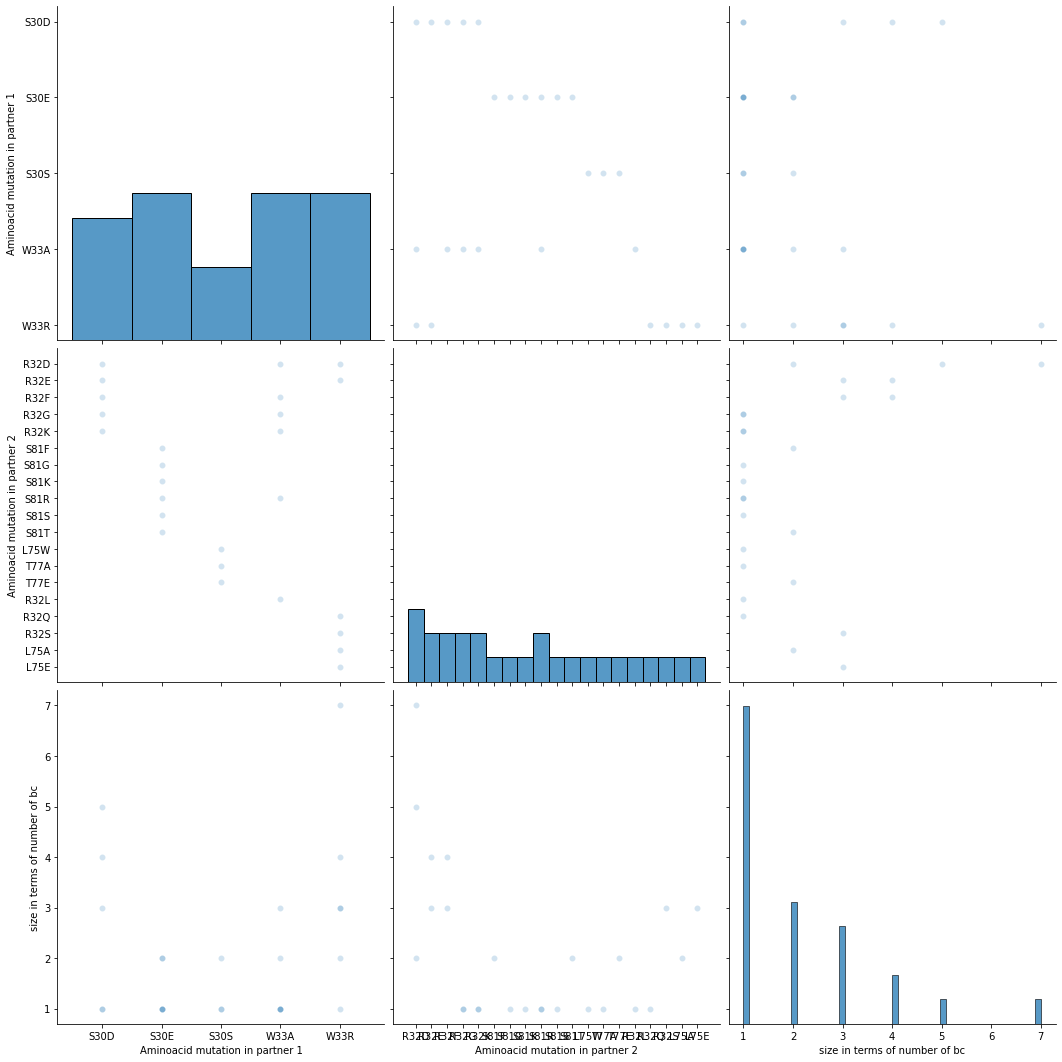

In [12]:
n_samples_to_plot = 2000
columns = ["Aminoacid mutation in partner 1", "Aminoacid mutation in partner 2", "size in terms of number of bc"]
_ = sns.pairplot(
    data=df_DOUBLEMUT_ENRICH[:n_samples_to_plot],
    vars=columns,
    plot_kws={"alpha": 0.2},
    height=5,
    diag_kind="hist",
    diag_kws={"bins": 50},
)